# Multiparticle states and entanglement
-----------------------------------------------------------

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

Let's introduce the Hadamard gate: $\hat{H}\left|+\right\rangle = \left|+\right\rangle_{x}$, $\hat{H}\left|-\right\rangle = \left|-\right\rangle_{x}$. Note the unfortunate double duty played by $\hat{H}$ in representing the Hadamard operation <i>as well as</i> the Hamiltonian. Fortunately, we're not going to deal with dynamics here, so there's no need to invoke a Hamiltonian. In situations where both are present (time evolution of multiparticle states, perhaps), we'll generally use slightly different flavors of "H" (e.g., $\mathcal{H}$ might denote the Hamiltonian). 

The Hadamard operation has the following matrix representation:

$\displaystyle \hat{H} \dot{=} \frac{1}{\sqrt{2}}\left(\begin{array}{cc} 1 & 1 \\ 1 & -1\end{array}\right)$

Note, however, that this is just a $\hat{U}$ gate with $\theta = \frac{\pi}{2}$, $\phi = 0$, $\lambda = \pi$ where

$\displaystyle \hat{U}(\theta,\phi,\lambda) = \left(\begin{array}{cc} \cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2}\\ e^{i\phi}\sin\frac{\theta}{2} & e^{-i(\phi + \lambda)}\cos\frac{\theta}{2}\end{array}\right)$.

Because this particular gate (which takes the states $\left|\pm\right\rangle$ to $\left|\pm\right\rangle_{x}$, respectively) is so commonly used, it's often invoked as ```h(qr)``` directly instead of using ```u(0.5*np.pi,0,np.pi)```.

One can quickly verify that this gate does take $\left|+\right\rangle$ to $\left|+\right\rangle_{x}$ by applying it to newly initialized qubits and measuring $\hat{S}^{z}$.

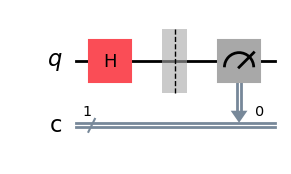

In [2]:
qr = QuantumRegister(1,'q')
cr = ClassicalRegister(1,'c')

hcirc = QuantumCircuit(qr,cr)
hcirc.h(0)
hcirc.barrier(range(1))
hcirc.measure(qr, cr)
hcirc.draw('mpl')

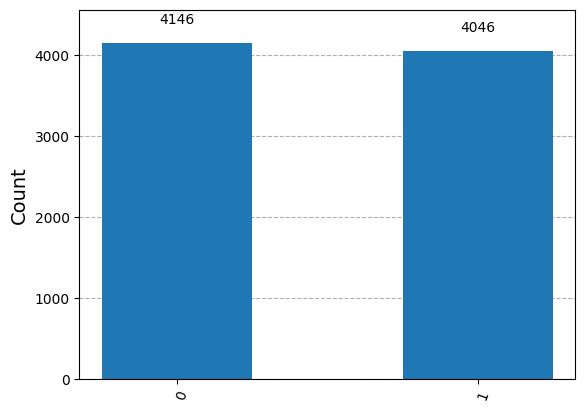

In [3]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (hcirc)
job = sampler.run([pub], shots=nshots)

result = job.result()[0]

counts = result.data.c.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts)

As expected, we find half the states to be $\left|+\right\rangle$ and the other half to be $\left|-\right\rangle$, entirely consistent with the Hadamard gate creating $\left|+\right\rangle_{x}$ from the initialized $\left|+\right\rangle$ states.

Now let's talk <i>entanglement</i>, and try to create the following state:

$\left|\psi\right\rangle = \frac{1}{\sqrt{2}}\left(\left|+\right\rangle\left|-\right\rangle - \left|-
\right\rangle\left|+\right\rangle \right),$

also sometimes written $\frac{1}{\sqrt{2}}\left(\left|+-\right\rangle - \left|-+\right\rangle \right).$

Starting from $\left|++\right\rangle$, we can apply $\hat{H}$ to the first spin, obtaining $\frac{1}{\sqrt{2}}\left(\left|++\right\rangle + \left|-+\right\rangle\right)$. 

Next, the second spin needs to be flipped to $\left|-\right\rangle$ <i>only</i> in the first term. One way of phrasing this task is: "if the first spin state is $\left|+\right\rangle$, change the state of the second spin from $\left|+\right\rangle$ to $\left|-\right\rangle$. This is our first example of a multispin (or multiqubit) gate. It turns out that the $CNOT$ (controlled "not") gate accomplishes almost this:

$CNOT\left|++\right\rangle = \left|++\right\rangle$

$CNOT\left|+-\right\rangle = \left|+-\right\rangle$

$CNOT\left|-+\right\rangle = \left|--\right\rangle$

$CNOT\left|--\right\rangle = \left|-+\right\rangle$

Here we use the first spin as the "control" spin. If the first state is $\left|-\right\rangle$, then the second state is swapped. Otherwise, the two-spin state is unchanged. This gate by itself won't turn our state into the singlet. <i>But</i> if we flip the second spin first

$\frac{1}{\sqrt{2}}\left(\left|++\right\rangle + \left|-+\right\rangle\right) \rightarrow \frac{1}{\sqrt{2}}\left(\left|+-\right\rangle + \left|--\right\rangle\right),$

an application of $CNOT$ takes us almost to the singlet. We can invoke $CNOT(\mbox{control},\mbox{target})$ in a circuit via ```cx(ctrl,targ)```. A now deprecated alternative used to be ```cnot(ctrl,targ)```, so get ready to have fun crashing older programs that haven't made the transition. 

The final step needs to change the sign of the $\left|-+\right\rangle$ term. This can be accomplished by the following unitary operation $\hat{U}(0, \pi, 0)$ acting on the first spin. This gate is equivalent to $\sigma^{z}$ and sometimes given the label $\hat{Z}$. Thus we need the following circuit:

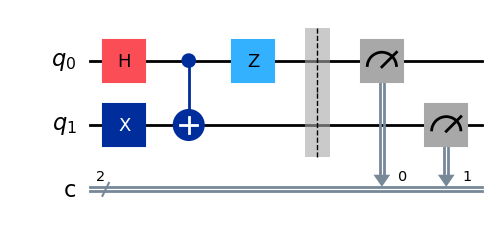

In [4]:
qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')
singlet = QuantumCircuit(qr,cr)
singlet.h(0)
singlet.x(1)
singlet.cx(0,1)
singlet.z(0)
singlet.barrier(range(2))
singlet.measure(qr, cr)
singlet.draw('mpl')

Measurement as employed above won't confirm the relative phase (and can't distinguish $\frac{1}{\sqrt{2}}\left(\left|+-\right\rangle - \left|-+\right\rangle\right)$ from $\frac{1}{\sqrt{2}}\left(\left|+-\right\rangle + \left|-+\right\rangle\right)$), but it does confirm that our state is an equal combination of $\left|+-\right\rangle$ and $\left|-+\right\rangle$.

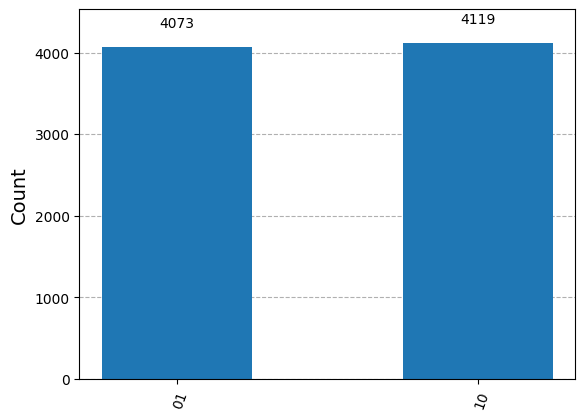

In [5]:
sampler = StatevectorSampler()

nshots = 8192

pub = (singlet)
job = sampler.run([pub], shots=nshots)

result = job.result()[0]

counts = result.data.c.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts)

Recall that in interpreting these states, we need to remember the correspondence '0' $\rightarrow\left|+\right\rangle$, '1'$\rightarrow \left|-\right\rangle$. To address the phase, you can actually build this circuit in the IBM Circuit Composer and see the phase displayed. Alternatively, we can perform a series of measurements which distinguish these two states. 

One trick is to measure $\hat{S}^{2} \equiv \left[\hat{S}^{x}\right]^{2} + \left[\hat{S}^{y}\right]^{2} + \left[\hat{S}^{z}\right]^{2}$ for both states. For a two-spin state, we have 

$$\hat{S}^{x} = \hat{S}_{1}^{x} + \hat{S}^{x}_{2},$$

where $\hat{S}^{x}_{i}$ refers to the $x$ projection of spin for the $i^{th}$ spin. Identically structured expressions exist for the other spin components. To calculate this expectation value analytically, one needs to remember that <i>all</i> operators acting on a two-spin state are actually tensor products of individual operators acting on both spins, though one might be trivial. Specifically, the spin component operators are

$$\hat{S}^{x}_{1} \equiv \hat{S}^{x}\otimes\hat{I},$$
$$\hat{S}^{x}_{1} \equiv \hat{I}\otimes\hat{S}^{x},$$

where $\hat{I}$ is the identity operator and $\hat{S}^{x}$ is the usual operator corresponding to the $x$ projection of a single spin, represented by a $2\times 2$ matrix. This distinction is not important for our experimental approach if we use the Sampler primitive and reconstruct expectation values. But remember how much easier the Estimator is for expectation values? We'll come back to this point momentarily. 

Our goal is to measure all three (squared) spin components for the singlet state. 

$$|\mbox{singlet}\rangle = \frac{1}{\sqrt{2}}\left(|+-\rangle - |-+\rangle\right)$$

Just to show we're actually able to measure this phase (minus sign), let's go ahead and also measure the same thing for the "triplet" Bell state

$$|\mbox{triplet}\rangle = \frac{1}{\sqrt{2}}\left(|+-\rangle + |-+\rangle\right)$$

The singlet/triplet terminology arises because of how two spins combine into an effective lump of spin. Basis choice is key in quantum mechanics. When considering a composite system, the "good quantum numbers" (nicely behaving quantities) are generally things like total spin. If you think about all the ways to arrange two spin-$\frac{1}{2}$ states, you get combinations with $z$ projection of spin $\pm 1$ ($|++\rangle$, $|--\rangle$) and zero ($|+-\rangle$, $|-+\rangle$). That's only part of the story, but the first two suggest that part of this lump behaves like a spin-$1$ particle. Those are actually the $\pm \hbar$ eigenstates of the spin-$1$ $\hat{S}^{z}$ operator. The other two <i>aren't</i>, but one linear combination is, and that's exactly what we're calling the <i>triplet</i> state. More properly, we should say it's <i>part of</i> the triplet of spin-$1$ states. The other linearly independent combination is the singlet, and it corresponds to a lump with no spin whatsoever... a <i>single</i>, spinless lump. 

So here's the strategy. We create a circuit for each state and run the estimator to get expectation values for all spin components. As it turns out, we can bundle each circuit and the needed observables into a single PUB and bundle the two PUBs as a single job. 

The paper's description involved a separate circuit for each component, as this used to be the only way to accomplish this task (at the time the paper was submitted). Since the ```Estimator``` primitive makes this task much easier and the other notebooks present the basic approach using the ```Sampler``` estimator, we'll focus on ```Estimator``` here. It's a worthwhile endeavor to translate this task into a form appropriate ```Sampler``` which makes use of the count data.
<!---fairly reasonable middle ground: A spin measurement is fairly easy to be cast in terms of parameters. We have already seen how to perform a spin measurement in some arbitrary direction $\hat{n}(\theta,\phi)$. $\hat{S}^{x}$ corresponds to $\theta = \frac{\pi}{2}$, $\phi = 0$, $\hat{S}^{y}$ corresponds to $\theta = \frac{\pi}{2}$, $\phi = \frac{\pi}{2}$, and $\hat{S}^{z}$ corresponds to $\theta = 0$, $\phi = 0$ (or anything). Since the states are entangled, measuring one spin determines which value will be obtained from the measurement of the second spin (along that same direction). So we have to do these spin measurements independently (doubling the number of circuits, or at least the depth!). We'll make two copies of each state on a four-qubit circuit with the top two qubits for measuring the first spin and the bottom two for measuring the second spin. Each "subcircuit" is an identical set of gates with only the measurement differing. This <i>will</i> complicate the output, but it's not too bad with only two measurements. We need something like:-->

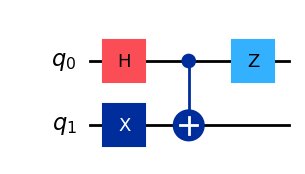

In [6]:
qr = QuantumRegister(2,'q')

singletcirc = QuantumCircuit(qr)
#singlet state
singletcirc.h(0)
singletcirc.x(1)
singletcirc.cx(0,1)
singletcirc.z(0)
singletcirc.draw('mpl')

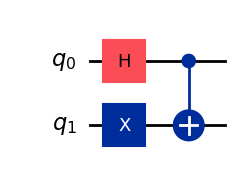

In [7]:
qr = QuantumRegister(2,'q')

tripletcirc = QuantumCircuit(qr)
#triplet state
tripletcirc.h(0)
tripletcirc.x(1)
tripletcirc.cx(0,1)
tripletcirc.draw('mpl')

Now that we have <i>two</i> spins, we have to build operators in the two-spin Hilbert space. Thus, we need $\hat{S}_{1}^{x} = \hat{S}^{x}\otimes\hat{I}$, $\hat{S}_{2}^{x} = \hat{I}\otimes\hat{S}^{x}$, with similar operators for the other components. 

But there's a crucial simplification here. We are attempting to measure the squared spin operator, 

$$\hat{S}^{2} = \left[\hat{S}_{1}^{x} + \hat{S}_{2}^{x}\right]^{2} + \left[\hat{S}_{1}^{y} + \hat{S}_{2}^{y}\right]^{2} + \left[\hat{S}_{1}^{z} + \hat{S}_{2}^{z}\right]^{2}$$

Here $\hat{S}_{1,2}^{x,y,z}$ are just spin-$\frac{1}{2}$ operators attached to an identity operator for the other spin. Thus, they satisfy the same algebra as the spin-$\frac{1}{2}$ operators. Simplifying, we have

$$\hat{S}^{2} = \hat{S}_{1}^{2} + \hat{S}_{2}^{2} + 2\hat{\bf S}_{1}\cdot \hat{\bf S}_{2}$$

Here, $\hat{S}_{1}^{2} \equiv \left[\hat{S}_{1}^{x}\right]^{2} + \left[\hat{S}_{1}^{y}\right]^{2} + \left[\hat{S}_{1}^{z}\right]^{2}$ and similarly for $\hat{S}_{2}^{2}$. The last term is shorthand for

$$\hat{\bf S}_{1}\cdot \hat{\bf S}_{2} = \hat{S}^{x}\otimes \hat{S}^{x} + \hat{S}^{y}\otimes \hat{S}^{y} + \hat{S}^{z}\otimes \hat{S}^{z}.$$

It's simple enough to use the $2\times 2$ Pauli representation of the single spin-$\frac{1}{2}$ operators to show

$$\hat{S}_{1}^{2} = \hat{S}_{2}^{2} = \frac{3\hbar^{2}}{4}\hat{I}.$$

Thus, for some state $\left|\psi\right\rangle$, we expect an average of a large number of measurements of $\hat{S}^{2}$ to yield

$$\left\langle \hat{S}^{2}\right\rangle = \frac{3\hbar^{2}}{2} + 2\left\langle \hat{\bf S}_{1} \cdot \hat{\bf S}_{2}\right\rangle.$$

That is, effectively we only need to measure $\left\langle \hat{\bf S}_{1} \cdot \hat{\bf S}_{2}\right\rangle$ to measure $\hat{S}^{2}$. 
Fortunately, there's a highly intuitive notation to construct these thre terms almost effortlessly.

In [8]:
from qiskit.quantum_info import SparsePauliOp

XX = SparsePauliOp.from_list([("XX", 0.25)])
YY = SparsePauliOp.from_list([("YY", 0.25)])
ZZ = SparsePauliOp.from_list([("ZZ", 0.25)])

Each circuit is then bundled as before with the appropriate observables and run on the simulator. 

In [9]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

pub1 = (
    singletcirc,  # circuit
    [XX, YY, ZZ],  # Observables
)

pub2 = (
    tripletcirc,  # circuit
    [XX, YY, ZZ],  # Observables
)

job_result = estimator.run(pubs=[pub1, pub2]).result()

Each PUB gets its own "result" output from which we can compute expectation values. For the triplet, we get

In [10]:
xxt = job_result[1].data.evs[0]
yyt = job_result[1].data.evs[1]
zzt = job_result[1].data.evs[2]

A spin-$s$ state has total squared spin $s(s+1)\hbar^{2}$, so we get 

In [11]:
1.5 + 2.0*(xxt+yyt+zzt)

2.0

That's of the form $1(1+1)$, so $s = 1$. That's what we expect for the triplet state!

For the singlet state, we get

In [12]:
xxs = job_result[0].data.evs[0]
yys = job_result[0].data.evs[1]
zzs = job_result[0].data.evs[2]

In [13]:
1.5 + 2.0*(xxs+yys+zzs)

4.440892098500626e-16

This is effectively zero, which is consistent with $0(0+1)$, or $s =0$. That's the singlet. This is one way of thinking at a high level about the difference between these two states: $|\mbox{singlet}\rangle$ corresponds to $s=0$, while $|\mbox{triplet}\rangle$ corresponds to $s=1$. 

Inserting the "missing" factors of $\hbar$, we conclude

$$\left\langle \hat{S}^{2}\right\rangle = \left\{\begin{array}{cc} 1\cdot(1+1)\hbar^{2} & (\mbox{triplet})\\ 0 & (\mbox{singlet})\end{array}\right.$$

Single qubits map to spin-$\frac{1}{2}$ degrees of freedom. When we consider the state describing multiple qubits, we find that such a state can map to a general spin-$s$ state for which$^{\dagger}$ $\hat{S}^{2} \rightarrow s(s+1)\hbar^{2}\hat{I}$ with $s = 0,\frac{1}{2},1,\frac{3}{2},\cdots$. Comparing this to our observations, we find that the triplet state is actually a spin-$1$ state, while the singlet is spin-0 (no internal spin degree of freedom). 

At a simpler level, we've found a particular observable ($\hat{\bf S}_{1}\cdot \hat{\bf S}_{2}$) for which the closely-related singlet and triplet states give different values. This quantity $\left\langle \hat{\bf S}_{1}\cdot\hat{\bf S}_{2}\right\rangle$ is actually an example of something refered to as a <i>correlation function</i>. If we take a closer look at the invidual pieces, we can gain some insight into the quantum state:

In [14]:
print('<Sx1 Sx2> = '+str(xxs))
print('<Sy1 Sy2> = '+str(yys))
print('<Sz1 Sz2> = '+str(zzs))

<Sx1 Sx2> = -0.24999999999999994
<Sy1 Sy2> = -0.24999999999999994
<Sz1 Sz2> = -0.24999999999999994


In [15]:
print('<Sx1 Sx2> = '+str(xxt))
print('<Sy1 Sy2> = '+str(yyt))
print('<Sz1 Sz2> = '+str(zzt))

<Sx1 Sx2> = 0.24999999999999994
<Sy1 Sy2> = 0.24999999999999994
<Sz1 Sz2> = -0.24999999999999994


Both states show anticorrelation in the individual measurements of $\hat{S}^{z}$. This makes sense, because both states are composed of $\left|+-\right\rangle$ and $\left|-+\right\rangle$, so there's no possible way to have both spins in the same eigenstate of $\hat{S}^{z}$. That relative phase ($e^{i0} = 1$ vs. $e^{i\pi} = -1$ makes a significant difference in the correlations between the spins with respect to $\hat{S}^{x}$ and $\hat{S}^{y}$. 

For the "triplet" state, the positive correlations $\left\langle \hat{S}^{x}_{1}\hat{S}_{2}^{x}\right\rangle$ and $\left\langle \hat{S}^{y}_{1}\hat{S}_{2}^{y}\right\rangle$ indicate that the $x$ and $y$ projections of the individual spins have a tendency to align. Classically, one thinks of spin as a little arrow of magnitude $\frac{\hbar}{2}$ which points along some axis in three-dimensional space. Combining two spins results in a new type of quantum state whose interpretation is not so simple. It is possible to identify this state as an effective spin-1 state with $\left\langle \hat{S}^{z} \right\rangle = 0$. In the classical picture, this corresponds to a little vector of magnitude $\hbar$ which has no projection along $z$ and lives in the $xy$ plane. Of course, this state <i>isn't</i> a classical vector in real space. But this sloppy picture is roughly reflected in the structure of the correlations. 

The singlet state is a bit more interesting. All correlations are negative. The individual spins appear <i>entirely</i> anticorrelated, regardless of the direction. Consequently, it should not be too surprising to learn that this two-particle state can be viewed effectively as a spinless ($s = 0$) state. To really dig in to these correlations, let's look more closely at how they change for both states as the spin axis is varied. For simplicity, let's just keep $\phi = 0$ and vary $\theta$ from 0 to $\pi$. We'll "cheat" by performing a rotation of $-\theta$ about the $y$ axis on the system and measure $\hat{S}^{z}\hat{S}^{z}$. You can convince yourself this is equivalent to measuring $\hat{S}^{\theta}\hat{S}^{\theta}$ on the <i>un</i>rotated (original) system. 

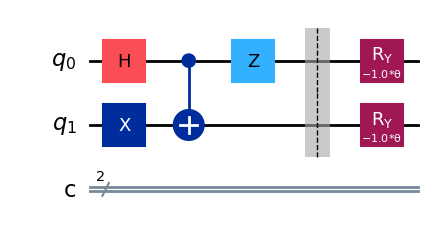

In [16]:
from qiskit.circuit import Parameter
theta = Parameter('θ')

qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')

singletcircθ = QuantumCircuit(qr,cr)
#singlet state
singletcircθ.h(0)
singletcircθ.x(1)
singletcircθ.cx(0,1)
singletcircθ.z(0)
singletcircθ.barrier(qr)
singletcircθ.ry(-theta,qr)
singletcircθ.draw('mpl')

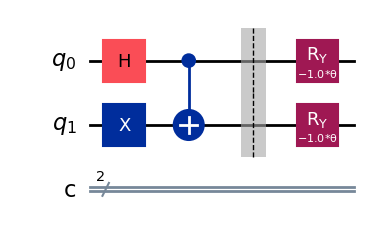

In [17]:
qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')

tripletcircθ = QuantumCircuit(qr,cr)
#triplet state
tripletcircθ.h(0)
tripletcircθ.x(1)
tripletcircθ.cx(0,1)
tripletcircθ.barrier(qr)
tripletcircθ.ry(-theta,qr)
tripletcircθ.draw('mpl')

In [18]:
Ntheta = 100
theta_range = np.linspace(0,np.pi,Ntheta)

We'll run both of these on the simulator. This means we get multiple circuits and multiple parameter values packaged into a single job.

In [19]:
estimator = StatevectorEstimator()

pub1 = (
    singletcircθ,  # circuit
    [ZZ],         # Observables
    theta_range,  # parameters
)

pub2 = (
    tripletcircθ,  # circuit
    [ZZ],  # Observables
    theta_range,  # parameters
)

job_result = estimator.run(pubs=[pub1, pub2]).result()

The analysis is roughly the same, but now we can make a plot of the $\langle \hat{S}^{\theta}\hat{S}^{\theta}\rangle$ correlation function.

In [20]:
zzsθ = job_result[0].data.evs
zztθ = job_result[1].data.evs

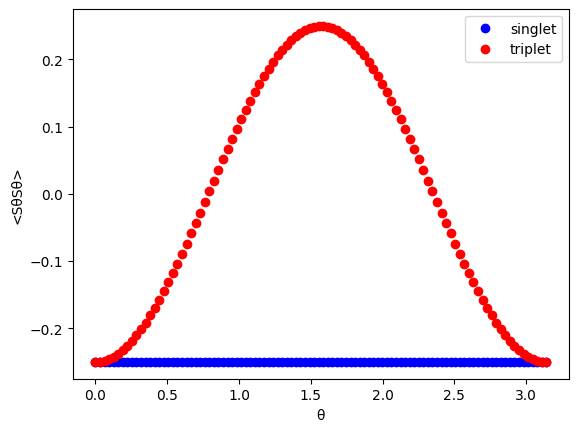

In [21]:
from matplotlib import pyplot as plt

plt.plot(theta_range,zzsθ,'bo',label='singlet')
plt.plot(theta_range,zztθ,'ro',label='triplet')
plt.xlabel('θ')
plt.ylabel('<SθSθ>')
plt.legend()
plt.show()

Let's run this on an actual device to see what happens with this more complicated system. Again, we just need to convert the circuits and observables to ISA and call a real device (see ```SingleSpin.ipynb``` for more details).

In [131]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibm_osaka'

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_singlet = pm.run(singletcircθ)
isa_triplet = pm.run(tripletcircθ)

isa_zz1 = ZZ.apply_layout(layout=isa_singlet.layout)
isa_zz2 = ZZ.apply_layout(layout=isa_triplet.layout)

pub1 = (
    isa_singlet,  # circuit
    [isa_zz1],         # Observables
    theta_range,  # parameters
)

pub2 = (
    isa_triplet,  # circuit
    [isa_zz2],  # Observables
    theta_range,  # parameters
)

from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

estimator = Estimator(backend)
job = estimator.run(pubs=[pub1,pub2])

result = job.result()

In [133]:
from qiskit_ibm_runtime import QiskitRuntimeService

job = service.job('ct88bvf7rgf00085mtag')
job_result = job.result()

In [134]:
zzsθq = job_result[0].data.evs
zztθq = job_result[1].data.evs

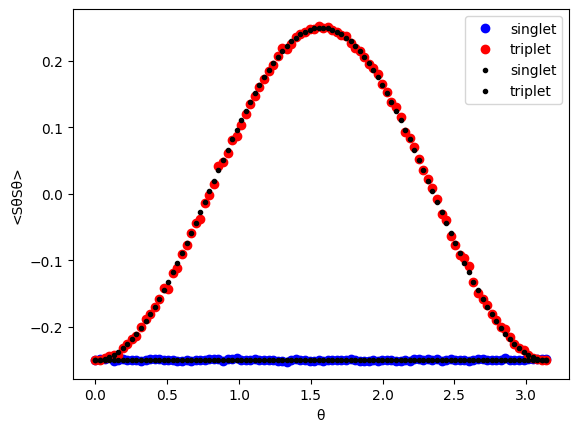

In [135]:
plt.plot(theta_range,zzsθq,'bo',label='singlet')
plt.plot(theta_range,zztθq,'ro',label='triplet')
plt.plot(theta_range,zzsθ,'k.',label='singlet')
plt.plot(theta_range,zztθ,'k.',label='triplet')
plt.xlabel('θ')
plt.ylabel('<SθSθ>')
plt.legend()
plt.show()

Agreement between simulation (black dots) and actual results (colored circles) is actually <i>pretty good</i>. Note that on ```ibm_osaka``` this job ate up <b>4 minutes and 17 seconds</b> of the free ten minutes one gets each month.

-----------------------------------

Consider a state which interpolates between the singlet and triplet state,

$$\left|\psi(\phi)\right\rangle = \frac{1}{\sqrt{2}}\left(\left|+\right\rangle\left|-\right\rangle +e^{i\phi}\left|-\right\rangle\left|+\right\rangle\right),$$

for $0 \leq \phi\leq \pi$. Let us calculate and plot the three correlation functions, $\left\langle \hat{S}^{\alpha}\otimes\hat{S}^{\alpha}\right\rangle$ for $\alpha = x,y,z$ as functions of the angle $\phi$.

The trick with this state is to apply a unitary gate $U(\frac{1}{\sqrt{2}},\phi,0)$ instead of the basic Hadamard gate. We can use $\phi$ as a parameter, and we don't need to final $Z$ gate to flip the sign to create a singlet state. It's easiest to calculate the correlation functions using separate circuits since $\phi$ is already being used to parameterize the state.

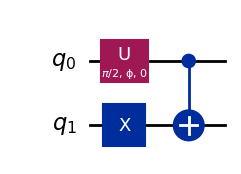

In [22]:
phi = Parameter('ϕ')
Nphi = 100

phi_vals = np.linspace(0,np.pi,Nphi)

qr = QuantumRegister(2,'q')

circ = QuantumCircuit(qr) 
circ.u(np.pi/2,phi,0,0)
circ.x(1)
circ.cx(0,1)
circ.draw('mpl')

In [23]:
from qiskit.quantum_info import SparsePauliOp

XX = SparsePauliOp.from_list([("XX", 0.25)])
YY = SparsePauliOp.from_list([("YY", 0.25)])
ZZ = SparsePauliOp.from_list([("ZZ", 0.25)])

from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

pub1 = (
    circ,  # circuit
    [[XX], [YY], [ZZ]],  # Observables
    phi_vals,
)

job_result = estimator.run(pubs=[pub1]).result()

In [24]:
xx = job_result[0].data.evs[0]
yy = job_result[0].data.evs[1]
zz = job_result[0].data.evs[2]

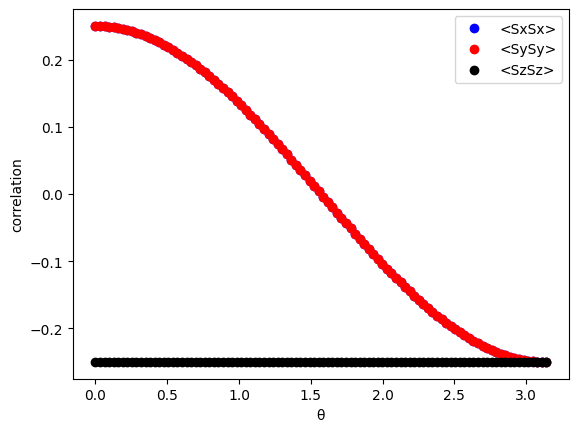

In [25]:
plt.plot(phi_vals,xx,'bo',label='<SxSx>')
plt.plot(phi_vals,yy,'ro',label='<SySy>')
plt.plot(phi_vals,zz,'ko',label='<SzSz>')
plt.legend()
plt.xlabel('θ')
plt.ylabel('correlation')
plt.show()

Thus, the $z$-component of correlations is always maximally negative while the transverse components interpolate smoothly from the triplet values to the singlet values. One can also perform a calculation with the spin operators to show

$$\left\langle \hat{S}^{x}\otimes\hat{S}^{x}\right\rangle = \left\langle \hat{S}^{y}\otimes\hat{S}^{y}\right\rangle  =  \frac{\hbar^{2}}{4}\cos\phi,$$

while $\left\langle \hat{S}^{z}\otimes\hat{S}^{z}\right\rangle  = -\frac{\hbar^{2}}{4}$, in agreement with the simulation.

## Version information:

In [26]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [27]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'